# Mn XRD

In [1]:
import numpy as np
import math
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import csv

In [2]:
wavelength = 0.1542 #nm
lattice_constant = 0.911 #nm

In [3]:
planes_df = pd.read_csv('All_Planes_hkl.csv')
miller_indices = planes_df.values

In [4]:
# Store this in a dataframe:
miller_list = [list(row) for row in miller_indices[:]]
df = pd.DataFrame({'Miller': miller_list})

In [5]:
df['hkl_squared'] = df['Miller'].apply(lambda x: x[0]**2 + x[1]**2 + x[2]**2)
df['sin theta (rad)'] = df['hkl_squared'].apply(lambda x: math.sqrt((wavelength**2/(4*lattice_constant**2))*x))
df['theta (rad)'] = df['sin theta (rad)'].apply(lambda x:(math.asin(x)))
df['theta (deg)'] = df['theta (rad)'].apply(lambda x: np.rad2deg(x))
df['2 theta (deg)'] = df['theta (deg)'].apply(lambda x: 2 * x)

In [6]:
df

,Miller,hkl_squared,sin theta (rad),theta (rad),theta (deg),2 theta (deg)
0,"[1, 0, 0]",1,0.084632,0.084734,4.854879,9.709759
1,"[1, 1, 0]",2,0.119688,0.119976,6.874103,13.748205
2,"[1, 1, 1]",3,0.146587,0.147118,8.429213,16.858425
3,"[2, 0, 0]",4,0.169265,0.170083,9.745061,19.490122
4,"[2, 1, 0]",5,0.189244,0.190392,10.908640,21.817280
5,"[2, 1, 1]",6,0.207306,0.208820,11.964517,23.929033
6,"[2, 2, 0]",8,0.239376,0.241723,13.849727,27.699454
7,"[2, 2, 1]",9,0.253897,0.256707,14.708226,29.416452
8,"[3, 0, 0]",9,0.253897,0.256707,14.708226,29.416452
9,"[3, 1, 0]",10,0.267631,0.270933,15.523331,31.046662


In [7]:
def store_atom_positions(csv_name):
    file_path = f"/Users/hendrikvossler/Desktop/GitHub/XRD/{csv_name}"
    
    atom_positions = {}

    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # skip the header
        for row in reader:
            atom_type = row[0]
            coords = list(map(float, row[1:]))
            if atom_type not in atom_positions:
                atom_positions[atom_type] = []
            atom_positions[atom_type].append(coords)

    # Convert lists to numpy arrays
    for atom_type, positions in atom_positions.items():
        atom_positions[atom_type] = np.array(positions)

    return atom_positions

In [8]:
# Read in the atom positions
atom_positions = store_atom_positions('Mn_atom_positions.csv')

In [9]:
# This calculates the term that will be multiplied by the atomic scattering factor
# for each atom type and for each miller incices
def compute_structure_factor_term(atom_positions, miller_indices_array):
    results = {}
    
    for miller_indices in miller_indices_array:
        h, k, l = miller_indices
        total = 0
        
        for position in atom_positions:
            position_adjusted = 2*position # distribute the 2 in the exponential factor to each atom position
            x, y, z = position_adjusted
            value = x * h + y * k + z * l

            # Check if value is even or 0
            if value % 2 == 0:
                total += 1
            # If value is odd
            else:
                total -= 1
        
        # Store the result with Miller indices as the key
        results[tuple(miller_indices)] = total
    
    return results

In [10]:
Mn_structure_factor_term = compute_structure_factor_term(atom_positions["Mn"], miller_indices)
print("Mn", Mn_structure_factor_term)


Mn {(1, 0, 0): -56, (1, 1, 0): -30, (1, 1, 1): -56, (2, 0, 0): -54, (2, 1, 0): -56, (2, 1, 1): -50, (2, 2, 0): -30, (2, 2, 1): -56, (3, 0, 0): -56, (3, 1, 0): -54, (3, 1, 1): -56, (2, 2, 2): -54, (3, 2, 0): -56, (3, 2, 1): -50, (4, 0, 0): -54, (3, 2, 2): -56, (4, 1, 0): -56, (3, 3, 0): -34, (4, 1, 1): -54, (3, 3, 1): -56, (4, 2, 0): -54, (4, 2, 1): -56, (3, 3, 2): -54, (4, 2, 2): -50, (5, 0, 0): -56, (4, 3, 1): -50, (5, 1, 0): -54, (3, 3, 3): -56, (5, 1, 1): -56, (4, 3, 2): -56, (5, 2, 0): -56, (5, 2, 1): -54, (4, 4, 0): -30, (4, 4, 1): -56, (5, 2, 2): -56, (4, 3, 3): -54, (5, 3, 0): -54, (5, 3, 1): -56, (4, 4, 2): -54, (6, 0, 0): -54, (6, 1, 0): -56, (5, 2, 3): -50, (6, 2, 0): -54, (4, 4, 3): -56, (5, 4, 0): -56, (5, 4, 1): -50, (5, 2, 4): -56, (4, 4, 4): -54}


In [11]:
# This calculates f, the atomic scattering factor, for each atom time at each theta angle 
def calc_atomic_scattering_factor(theta, atomic_number, a1, b1, a2, b2, a3, b3, a4=None, b4=None, wavelength = 0.1542):
    s = math.sin(theta)/(wavelength*10)
    f = atomic_number - (41.78214 * s**2) * (a1*np.e**(-b1*s**2) + a2*np.e**(-b2*s**2) + a3*np.e**(-b3*s**2) + a4*np.e**(-b4*s**2))
    return f

In [12]:
# Populate df with atomic scattering factors
df['Mn_f'] = df['theta (rad)'].apply(lambda x: calc_atomic_scattering_factor(x, 25, 2.747, 67.786, 2.456, 15.674, 1.792, 3, 0.498, 0.357))

In [13]:
# Define function to calculate multiplicity facor for each plane:
def get_unique_permutations(hkl):
    # Get all permutations of the Miller indices
    perms = list(itertools.permutations(hkl))
    
    # For each permutation, consider all possible sign changes
    all_permutations = []
    for perm in perms:
        signs = itertools.product([1, -1], repeat=3)
        for sign in signs:
            all_permutations.append(tuple([i*j for i, j in zip(perm, sign)]))
    
    # Return unique permutations (number of planes in family)
    return set(all_permutations)

In [14]:
# Calculate the structure factors using the atomic scattering factors- 
# i need to go through this math to make sure it is correct- 
# it definitely doesnt match the peak intensities given on materials project
#this is definitely where the error is- adding up the structure factor- it works for single atom but not for multiple atoms
df['Structure Factor'] = (df['Mn_f'] * df['Miller'].apply(lambda x: Mn_structure_factor_term[tuple(x)])) 
df['F^2'] = df['Structure Factor']**2
df['p'] = df['Miller'].apply(lambda x: len(get_unique_permutations(x)))
df['Lorentz_factor'] = df['theta (rad)'].apply(lambda x: (1+(math.cos(2*x)**2)) / (math.sin(x)**2 * math.cos(x)))
df['Intensity'] = df['F^2']*df['p']*df['Lorentz_factor']
df["Intensity_norm"] = (df["Intensity"]*100/df["Intensity"].max())


In [17]:
df # what do i do when two planes have the same 2 theta value and both diffract? do you add the intensities?
# on materials project, 1 0 0 and 210 both dont even show up??

,Miller,hkl_squared,sin theta (rad),theta (rad),theta (deg),2 theta (deg),Mn_f,Structure Factor,F^2,p,Lorentz_factor,Intensity,Intensity_norm
0,"[1, 0, 0]",1,0.084632,0.084734,4.854879,9.709759,24.137127,-1351.679113,1.827036e+06,6,276.247130,3.028281e+09,100.000000
1,"[1, 1, 0]",2,0.119688,0.119976,6.874103,13.748205,23.409733,-702.291994,4.932140e+05,12,136.653315,8.087920e+08,26.707954
2,"[1, 1, 1]",3,0.146587,0.147118,8.429213,16.858425,22.787035,-1276.073957,1.628365e+06,8,90.135411,1.174187e+09,38.774025
3,"[2, 0, 0]",4,0.169265,0.170083,9.745061,19.490122,22.245469,-1201.255351,1.443014e+06,6,66.886575,5.791098e+08,19.123380
4,"[2, 1, 0]",5,0.189244,0.190392,10.908640,21.817280,21.767047,-1218.954645,1.485850e+06,24,52.945442,1.888056e+09,62.347448
5,"[2, 1, 1]",6,0.207306,0.208820,11.964517,23.929033,21.338069,-1066.903475,1.138283e+06,24,43.658222,1.192690e+09,39.385042
6,"[2, 2, 0]",8,0.239376,0.241723,13.849727,27.699454,20.589345,-617.680357,3.815290e+05,12,32.064851,1.468041e+08,4.847768
7,"[2, 2, 1]",9,0.253897,0.256707,14.708226,29.416452,20.255748,-1134.321884,1.286686e+06,24,28.207439,8.710589e+08,28.764133
8,"[3, 0, 0]",9,0.253897,0.256707,14.708226,29.416452,20.255748,-1134.321884,1.286686e+06,6,28.207439,2.177647e+08,7.191033
9,"[3, 1, 0]",10,0.267631,0.270933,15.523331,31.046662,19.942833,-1076.912981,1.159742e+06,24,25.125792,6.993462e+08,23.093832


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

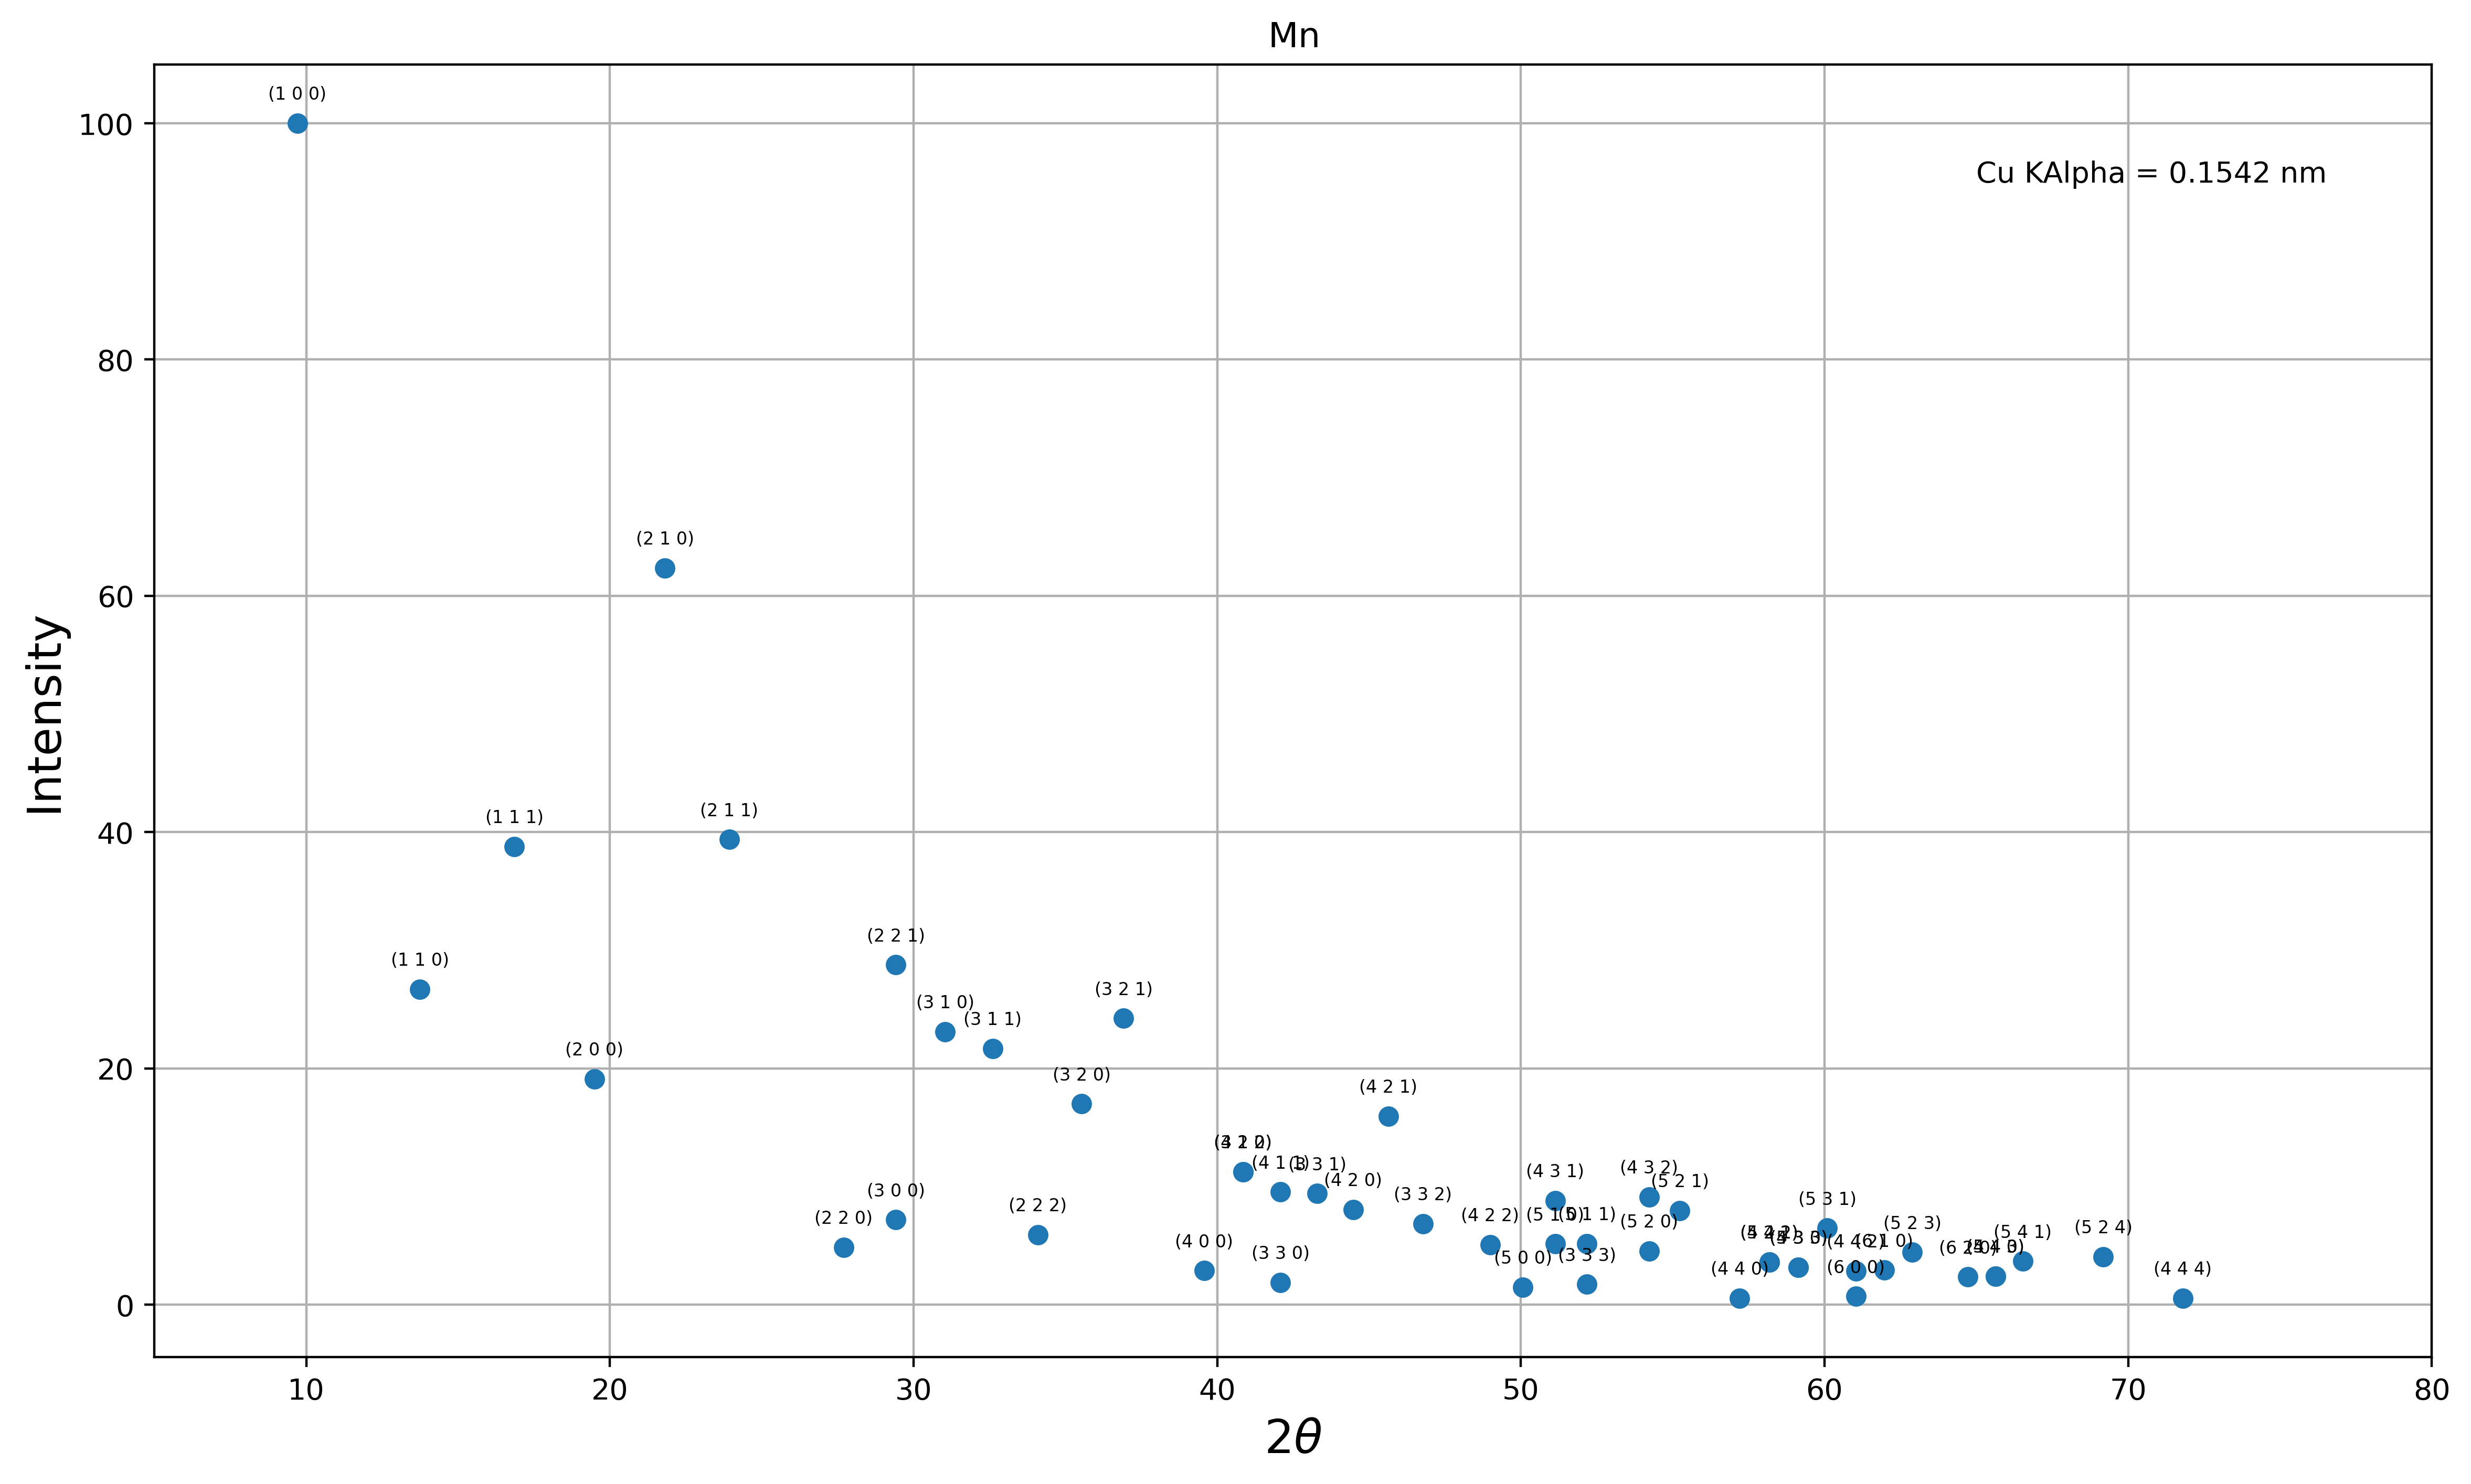

In [16]:
# Plot the XRD pattern
# Filter out forbidden reflections
fig = plt.figure(figsize=(14, 8), dpi = 400)
filtered_df = df[df['Intensity_norm'] != 0]
x = filtered_df['2 theta (deg)']
y = filtered_df['Intensity_norm']
plt.plot(x, y, 'o')

# Add text labels above each data point
for index, row in filtered_df.iterrows():
    label = str(row['Miller']).replace('[', '(').replace(']', ')').replace(',', '')
    x = row['2 theta (deg)']
    y = row['Intensity_norm']
    plt.text(x, y + 0.02 * max(filtered_df['Intensity_norm']), label, ha='center', fontsize=6)

# Figure formatting
plt.text(65, 95, "Cu KAlpha = 0.1542 nm")
plt.xlim(5, 80)
plt.xlabel("2"r'$\theta$', fontsize = 16)
plt.ylabel('Intensity', fontsize = 16)
plt.title(r'$\mathrm{Mn}$')
plt.grid()
plt.tight_layout
